2.0715529918670654
CT.1.2.840.113619.2.327.3.3423213578.912.1433712139.429.108-no-phi.dcm


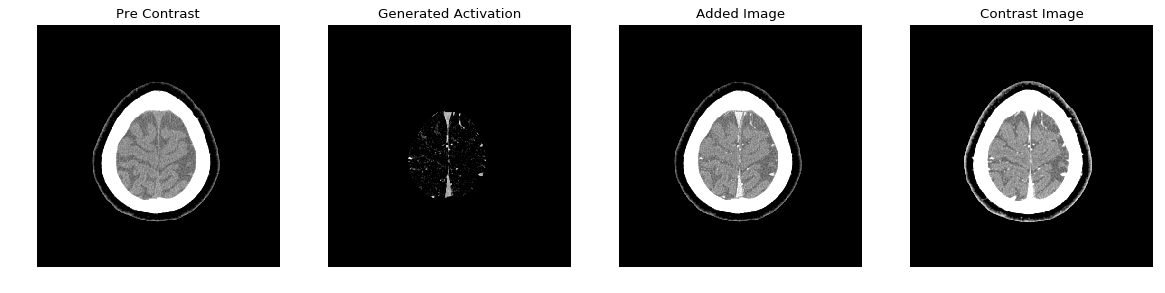

2.0836575031280518
CT.1.2.840.113619.2.334.3.487232533.786.1448229206.31.77-no-phi.dcm


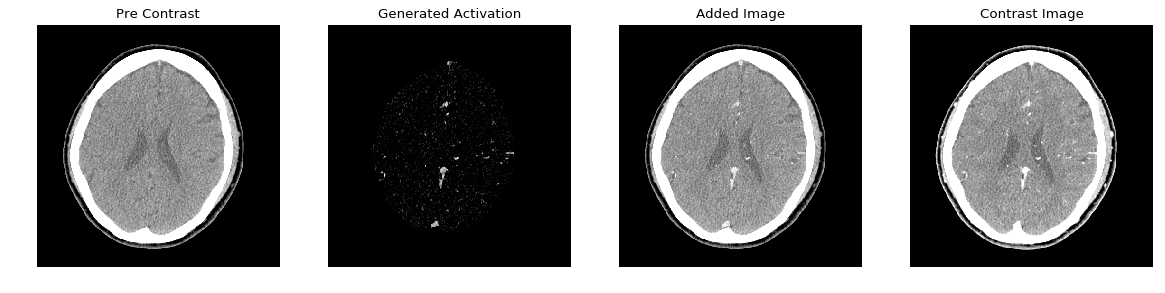

2.0413413047790527
CT.1.3.12.2.1107.5.1.4.65603.30000012050822203560900026898-no-phi.dcm


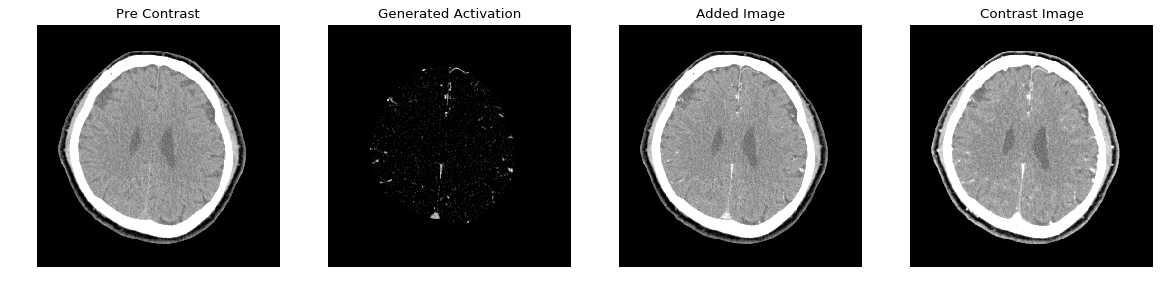

2.151947259902954
CT.1.2.840.113619.2.55.3.2919918340.525.1363556154.450.68-no-phi.dcm


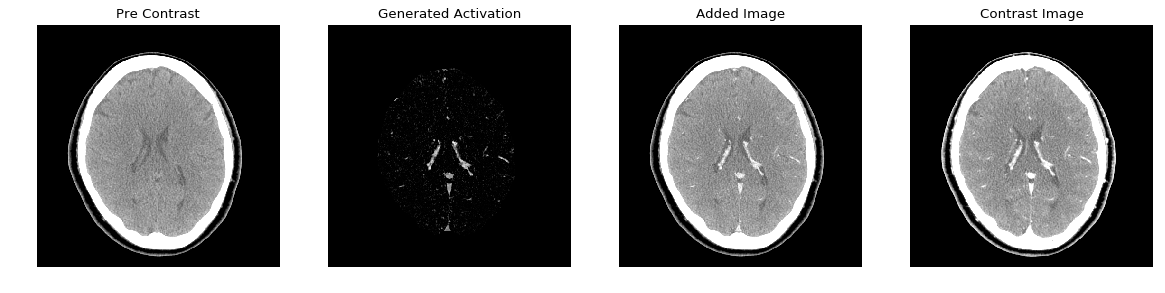

1.9536962509155273
CT.1.2.840.113619.2.327.3.3423213578.650.1392240957.272.23-no-phi.dcm


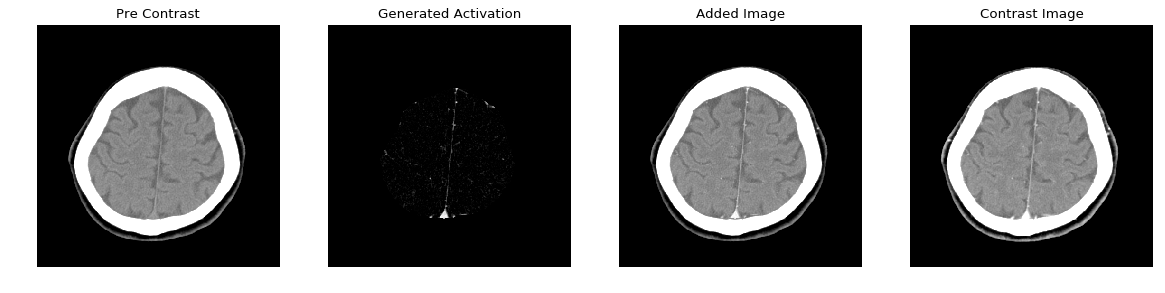

2.070317268371582
CT.1.2.840.113619.2.294.3.3423213578.196.1333404167.278.63-no-phi.dcm


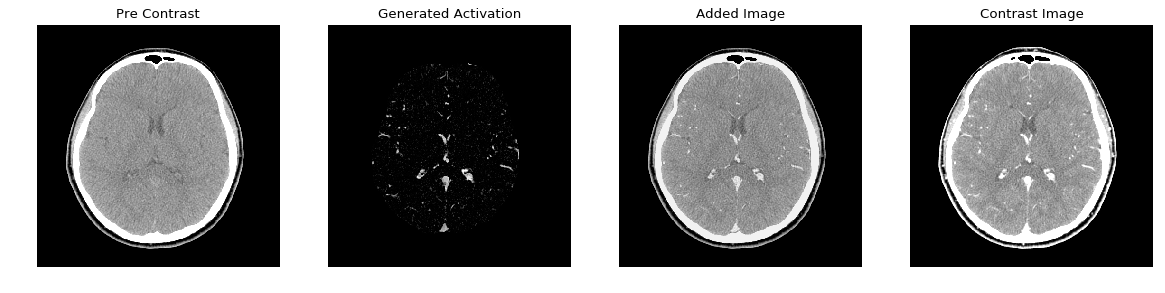

2.044696092605591
CT.1.3.12.2.1107.5.1.4.54635.30000015021022180575000028915-no-phi.dcm


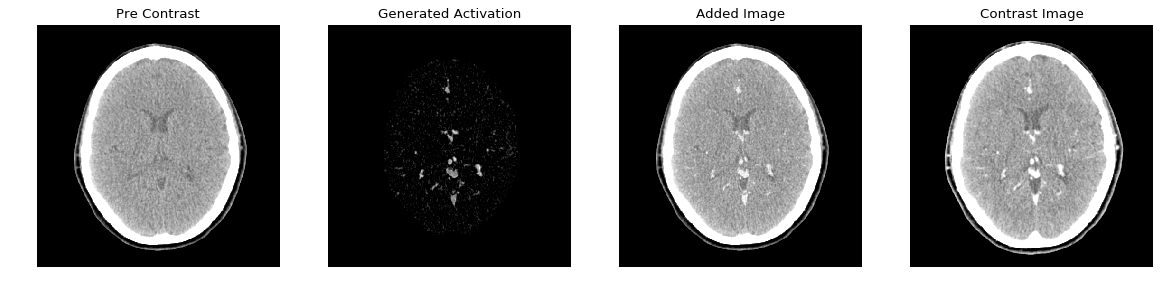

2.178255796432495
CT.1.2.840.113619.2.55.3.2919918340.897.1292363826.244.21-no-phi.dcm


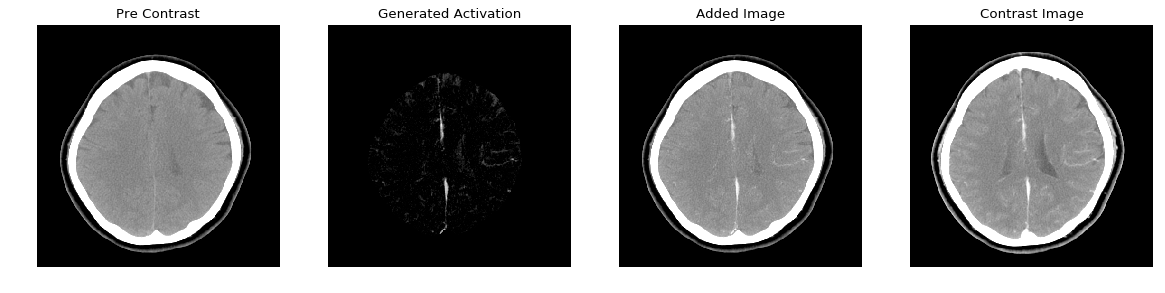

2.092597246170044
CT.1.2.840.113619.2.55.3.2919918340.977.1328650049.750.71-no-phi.dcm


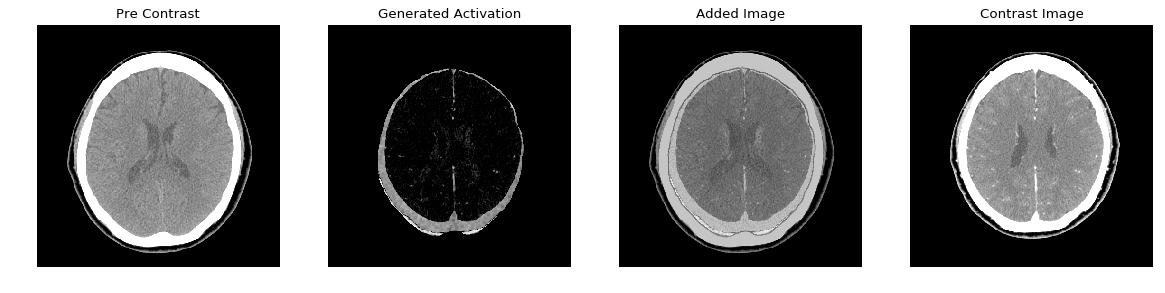

1.9558515548706055
CT.1.2.840.113619.2.327.3.3423213578.836.1428614411.726.90-no-phi.dcm


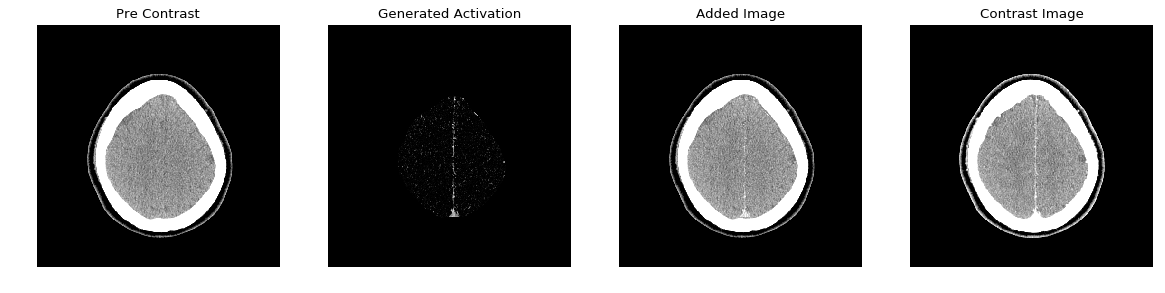

In [1]:
%matplotlib inline
from dataset import get_data
from utils import apply_window

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
import numpy as np 
import cv2 
import time 

def get_mask(ori_img):
    w, h = ori_img.shape 
    reshape = np.reshape(ori_img, [-1,1])
    kmeans = KMeans(n_clusters=3, random_state=0).fit(reshape)
    markers = np.reshape(kmeans.labels_, [w, h])
    
    nw = int(w / 2)
    nh = int(h / 2)
    markers = (markers == markers[nw, nh]).astype(np.uint8)
    _, labels = cv2.connectedComponents(markers)
    mask = (labels == labels[nw, nh]).astype(np.uint8) 
    # later version need to count most frequent value near center location 
    return mask


def get_local_(img, min_max='min', local_size=3):
    # img: uint8 
    width, height = img.shape
    out_img = np.zeros((width, height, (local_size*2+1)**2), dtype=np.uint8)
    ind = 0 
    for w in range(-local_size, local_size+1):
        for h in range(-local_size, local_size+1):
            rolled = np.roll(img, w, axis=1)
            rolled = np.roll(rolled, h, axis=0) 
            out_img[:,:,ind] = rolled
            ind += 1
    if min_max=='min':
        return np.min(out_img, axis=2)
    if min_max=='max':
        return np.max(out_img, axis=2)
    

def pixel_diff(ori, cont, local_size=2): 
    width, height = ori.shape 
    assert ori.shape == cont.shape
    
    out_img = np.zeros((width, height, (local_size*2+1)**2)) 
    ind = 0
    for w in range(-local_size, local_size+1):
        for h in range(-local_size, local_size+1):
            rolled = np.roll(ori, w, axis=1)
            rolled = np.roll(rolled, h, axis=0)
            out_img[:,:,ind] = rolled
            ind += 1
    out = abs(out_img - np.expand_dims(cont, axis=2))
    return np.min(out, axis=2)
            
batch_size = 10
x, y, names =  get_data(batch_size, wo_name=False)
for i in range(batch_size):
    start = time.time()
    a = apply_window(x[i])
    b = apply_window(y[i])

    mask = get_mask(a) 
    mask2 = get_local_(mask, 'max', 5)
    mask2 = get_local_(mask2, 'min', 7)

    diff = pixel_diff(a,b)
    tt = mask * diff

    end = time.time()
    print (end - start)

    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    
    plt.subplot(141)
    plt.title('Pre Contrast')
    plt.axis('off')
    plt.imshow(a, cmap='gray')

    plt.subplot(142)
    plt.title('Generated Activation')
    plt.axis('off')
    plt.imshow(mask2 * diff, cmap='gray')
    
    plt.subplot(143)
    plt.title('Added Image')
    plt.axis('off')
    plt.imshow(a + mask2 * diff, cmap='gray')
    
    plt.subplot(144)
    plt.title('Contrast Image')
    plt.axis('off')
    plt.imshow(b, cmap='gray')
    
    print (names[i])
    fig.savefig('imgs/'+str(i)+'_th_img.png', bbox_inches='tight')
    plt.show()

    